In [ ]:
!pip install transformers
!pip install pandas
!pip install torch
!pip install sklearn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EarlyStoppingCallback

# Cargar los datos desde el CSV
df = pd.read_csv('/content/cleaned_review.csv')

# Convertir etiquetas de sentimiento a números
df['sentimiento'] = df['sentimiento'].map({
    'negative': 0,
    'neutral': 1,
    'positive': 2
})

# Asegurarnos de que la columna 'sentimiento' es de tipo entero
df['sentimiento'] = pd.to_numeric(df['sentimiento'], errors='coerce').fillna(0).astype(int)

# Eliminar filas con NaN en la columna 'text'
df = df.dropna(subset=['text'])

# Verificar la distribución de clases antes del re-muestreo
print("Distribución de clases antes del re-muestreo:")
print(df['sentimiento'].value_counts())

# Asegurarnos de que hay más de una clase
if df['sentimiento'].nunique() > 1:
    # Re-muestreo de los datos
    X = df['text']
    y = df['sentimiento']

    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

    df_resampled = pd.DataFrame({'text': X_resampled.flatten(), 'sentimiento': y_resampled})

    # Eliminar filas con NaN en la columna 'text' después del re-muestreo
    df_resampled = df_resampled.dropna(subset=['text'])

    # División del conjunto resampleado en entrenamiento y validación
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df_resampled['text'], df_resampled['sentimiento'], test_size=0.2, random_state=42
    )

    # Tokenización
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    class SentimentDataset(Dataset):
        def __init__(self, texts, labels):
            self.texts = texts
            self.labels = labels

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=128,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # Crear datasets de entrenamiento y validación
    train_dataset = SentimentDataset(train_texts.values, train_labels.values)
    val_dataset = SentimentDataset(val_texts.values, val_labels.values)

    # Definir la función compute_metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = torch.argmax(torch.tensor(logits), dim=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='weighted', zero_division=0
        )
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    # Configuración del entrenamiento y Early Stopping
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        learning_rate=2e-5,
        warmup_steps=500,
        weight_decay=0.1,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

    # Ajustar el modelo para 3 clases
    trainer = Trainer(
        model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    # Entrenamiento del modelo
    trainer.train()
else:
    print("No se puede entrenar el modelo porque solo hay una clase presente en los datos.")


Distribución de clases antes del re-muestreo:
sentimiento
2    9503
1    6284
0    1534
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.225200,0.188296,0.929498,0.929230,0.929498,0.928756
2,0.105800,0.165151,0.958260,0.958218,0.958260,0.957951
3,0.077100,0.181262,0.966152,0.966074,0.966152,0.965965
4,0.034700,0.167535,0.972641,0.972724,0.972641,0.972610


In [ ]:
import pandas as pd

# Cargar los tres datasets desde archivos .xlsx
df1 = pd.read_excel('/content/amazon.xlsx')
df2 = pd.read_excel('/content/apple.xlsx')
df3 = pd.read_excel('/content/google.xlsx')

# Añadir una columna que identifique el producto
df1['producto'] = 'Amazon'
df2['producto'] = 'Apple'
df3['producto'] = 'Google'

# Concatenar los tres DataFrames en uno solo
df_combined = pd.concat([df1, df2, df3], ignore_index=True)

# Convertir todo en la columna 'text' a cadenas de texto
df_combined['text'] = df_combined['text'].astype(str)

# Eliminar filas con cadenas vacías o NaN
df_combined = df_combined[df_combined['text'].str.strip() != '']

# Verificar que las columnas 'text' y 'rating' están presentes
print(df_combined[['text', 'rating', 'producto']].head())


                                                text rating producto
0  I love it, it's so great and helpful everyday,...      5   Amazon
1  Bought this as a gift to my brother. He uses i...      5   Amazon
2  Love that bought this! Found this on sale for ...      5   Amazon
3  Perfect size, perfect oudio, everything is per...      5   Amazon
4  This is our 2nd Echo in our home. It works gre...      5   Amazon


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Cargar el tokenizer y el modelo previamente entrenado
tokenizer = BertTokenizer.from_pretrained("/content/modelo_entrenado")
model = BertForSequenceClassification.from_pretrained("/content/modelo_entrenado")

# Mover el modelo a la GPU
model = model.to('cuda')

# Procesar los datos en lotes
batch_size = 100  # Puedes ajustar el tamaño del lote según la memoria disponible

predicciones = []

for i in range(0, len(df_combined), batch_size):
    # Tokenizar el lote actual
    batch_texts = df_combined['text'][i:i+batch_size].tolist()
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

    # Mover los datos a la GPU
    inputs = {k: v.to('cuda') for k, v in inputs.items()}

    # Realizar predicciones
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Mover las predicciones a la CPU y convertirlas en etiquetas de sentimiento
    batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    predicciones.extend(batch_preds)

# Mapear las predicciones a etiquetas textuales
etiquetas = {0: "negative", 1: "neutral", 2: "positive"}
df_combined['sentimiento_predicho'] = [etiquetas[p] for p in predicciones]

# Verificar que la columna se ha creado correctamente
print(df_combined[['text', 'rating', 'producto', 'sentimiento_predicho']].head())


                                                text rating producto  \
0  I love it, it's so great and helpful everyday,...      5   Amazon   
1  Bought this as a gift to my brother. He uses i...      5   Amazon   
2  Love that bought this! Found this on sale for ...      5   Amazon   
3  Perfect size, perfect oudio, everything is per...      5   Amazon   
4  This is our 2nd Echo in our home. It works gre...      5   Amazon   

  sentimiento_predicho  
0             positive  
1             positive  
2             positive  
3             positive  
4             positive  


sentimiento_predicho  positive  neutral  negative  Sentimiento Compuesto
producto                                                                
Amazon                    1369      276        12               0.818950
Apple                      720      181        14               0.771585
Google                    1270      305        31               0.771482


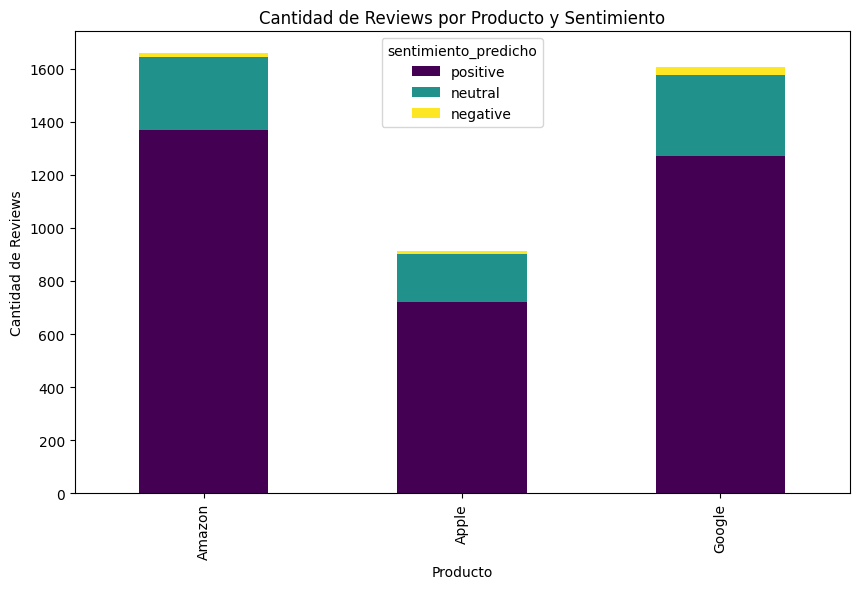

In [ ]:
import matplotlib.pyplot as plt

# Calcular la cantidad de reviews por cada sentimiento y producto
sentimiento_por_producto = df_combined.groupby('producto')['sentimiento_predicho'].value_counts().unstack().fillna(0)

# Calcular el sentimiento compuesto por cada producto
sentimiento_por_producto['Sentimiento Compuesto'] = (
    (sentimiento_por_producto['positive'] - sentimiento_por_producto['negative']) /
    (sentimiento_por_producto['positive'] + sentimiento_por_producto['neutral'] + sentimiento_por_producto['negative'])
)

# Mostrar los resultados
print(sentimiento_por_producto[['positive', 'neutral', 'negative', 'Sentimiento Compuesto']])

# Representar gráficamente la cantidad de reviews por sentimiento
sentimiento_por_producto[['positive', 'neutral', 'negative']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Cantidad de Reviews por Producto y Sentimiento')
plt.xlabel('Producto')
plt.ylabel('Cantidad de Reviews')
plt.show()


producto    Amazon     Apple    Google
rating                                
1.0      -0.214286 -0.185185 -0.307692
2.0       0.062500  0.080000 -0.038462
3.0       0.255319  0.282051  0.145455
4.0       0.653061  0.666667  0.649194
5.0       0.874126  0.880450  0.899413


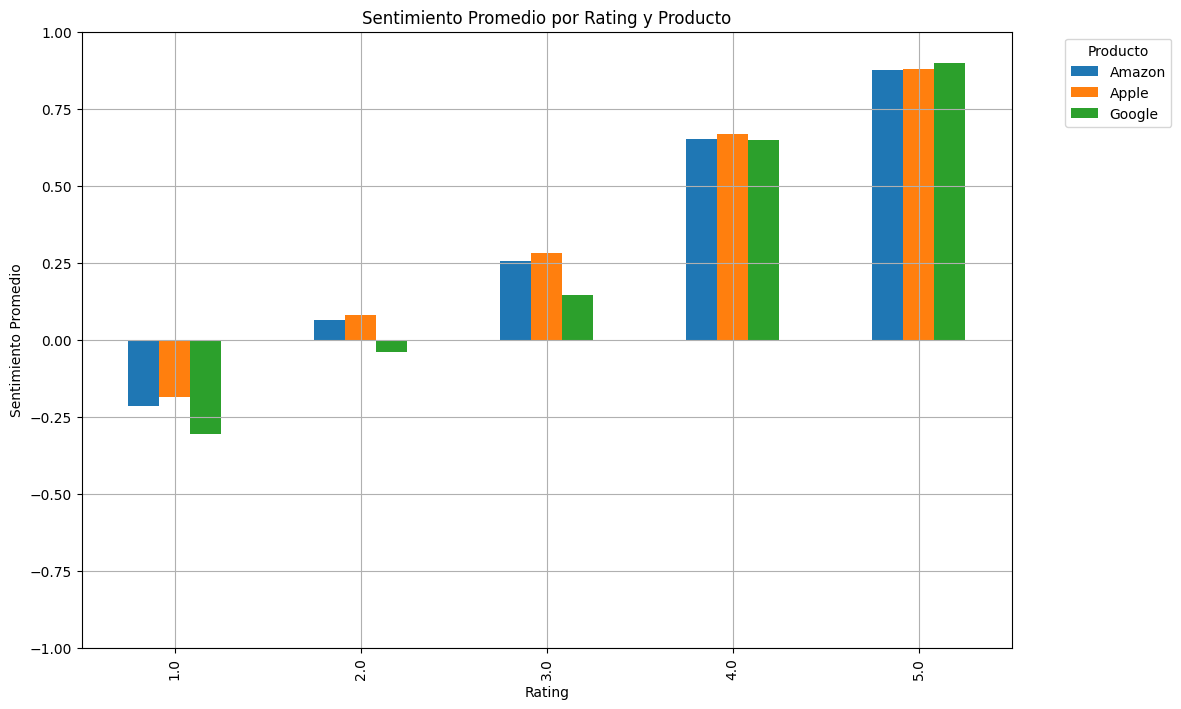

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que df_combined ya está preparado y tiene las columnas 'sentimiento_predicho', 'rating', y 'producto'

# Convertir 'rating' a numérico, en caso de que no lo sea
df_combined['rating'] = pd.to_numeric(df_combined['rating'], errors='coerce')

# Mapear los sentimientos predichos a valores numéricos
sentimiento_numerico = {'negative': -1, 'neutral': 0, 'positive': 1}
df_combined['sentimiento_numerico'] = df_combined['sentimiento_predicho'].map(sentimiento_numerico)

# Calcular el sentimiento compuesto promedio por cada rating y producto
sentimiento_promedio_por_rating_producto = df_combined.groupby(['rating', 'producto'])['sentimiento_numerico'].mean().unstack()

# Mostrar los resultados
print(sentimiento_promedio_por_rating_producto)

# Crear un gráfico de barras donde el eje X sea el rating y los productos estén representados en las series
sentimiento_promedio_por_rating_producto.plot(kind='bar', figsize=(12, 8))
plt.title('Sentimiento Promedio por Rating y Producto')
plt.xlabel('Rating')
plt.ylabel('Sentimiento Promedio')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# Asegúrate de que df_combined ya está preparado y tiene las columnas 'sentimiento_predicho', 'rating', 'producto', y 'text'

# Mapear los sentimientos predichos a valores numéricos (en caso de no haberse hecho antes)
sentimiento_numerico = {'negative': -1, 'neutral': 0, 'positive': 1}
df_combined['sentimiento_numerico'] = df_combined['sentimiento_predicho'].map(sentimiento_numerico)

# Función para extraer las top 5 reviews de cada categoría por producto
def extraer_top_reviews(df, producto, sentimiento_numerico, top_n=5):
    df_producto = df[df['producto'] == producto]
    mas_negativas = df_producto[df_producto['sentimiento_numerico'] == -1].nsmallest(top_n, 'rating')
    mas_neutrales = df_producto[df_producto['sentimiento_numerico'] == 0].sample(n=top_n)
    mas_positivas = df_producto[df_producto['sentimiento_numerico'] == 1].nlargest(top_n, 'rating')
    return mas_negativas, mas_neutrales, mas_positivas

# Iterar sobre los productos y extraer las top 5 reviews para cada sentimiento
for producto in df_combined['producto'].unique():
    mas_negativas, mas_neutrales, mas_positivas = extraer_top_reviews(df_combined, producto, sentimiento_numerico)

    print(f"Producto: {producto}")
    print("\n5 Reviews más negativas:")
    print(mas_negativas[['rating', 'text']])

    print("\n5 Reviews más neutrales:")
    print(mas_neutrales[['rating', 'text']])

    print("\n5 Reviews más positivas:")
    print(mas_positivas[['rating', 'text']])
    print("\n" + "="*50 + "\n")


Producto: Amazon

5 Reviews más negativas:
      rating                                               text
586      1.0  Kept saying it was in the wrong house instead ...
646      1.0  It’s not connecting to my Alexa app at all thi...
870      1.0  I purchased the 5th generation alexia ball and...
1005     1.0  I do not like the way it looks and it is very ...
1602     1.0  It did not work properly. It couldn't hear me ...

5 Reviews más neutrales:
      rating                                               text
971      4.0  Good quality sound and the price isnt bad eith...
89       5.0  It works fine, i havent had any issues with it...
1324     5.0  Works as described.  Will need to download Ale...
62       5.0  All the bells and whistles of Alexa with impro...
236      5.0  Works great, came on time. I thought it would ...

5 Reviews más positivas:
   rating                                               text
0     5.0  I love it, it's so great and helpful everyday,...
1     5.0  Boug

In [ ]:
# Calcular el sentimiento compuesto promedio por producto
sentimiento_por_producto = df_combined.groupby('producto')['sentimiento_numerico'].mean()

# Calcular el rating promedio por producto
rating_promedio_por_producto = df_combined.groupby('producto')['rating'].mean()

# Combinar ambos resultados en un DataFrame
resultado_final = pd.DataFrame({
    'Sentimiento Compuesto Promedio': sentimiento_por_producto,
    'Rating Promedio': rating_promedio_por_producto
})

# Calcular un "Score" final para cada producto combinando el sentimiento compuesto y el rating promedio
resultado_final['Score'] = (resultado_final['Sentimiento Compuesto Promedio'] + resultado_final['Rating Promedio']) / 2

# Determinar el mejor producto basado en el "Score"
mejor_producto = resultado_final['Score'].idxmax()

# Mostrar el mejor producto y su detalle
print(f"El mejor producto según el sentimiento compuesto y el rating promedio es: {mejor_producto}")
print(resultado_final.loc[mejor_producto])


El mejor producto según el sentimiento compuesto y el rating promedio es: Amazon
Sentimiento Compuesto Promedio    0.818950
Rating Promedio                   4.791415
Score                             2.805182
Name: Amazon, dtype: float64


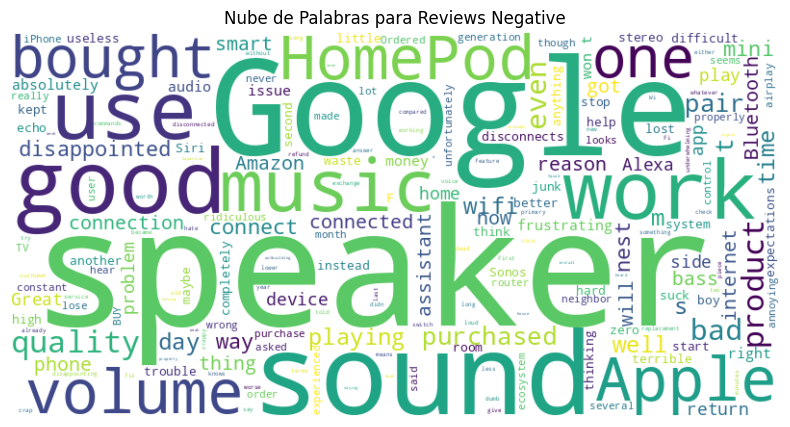

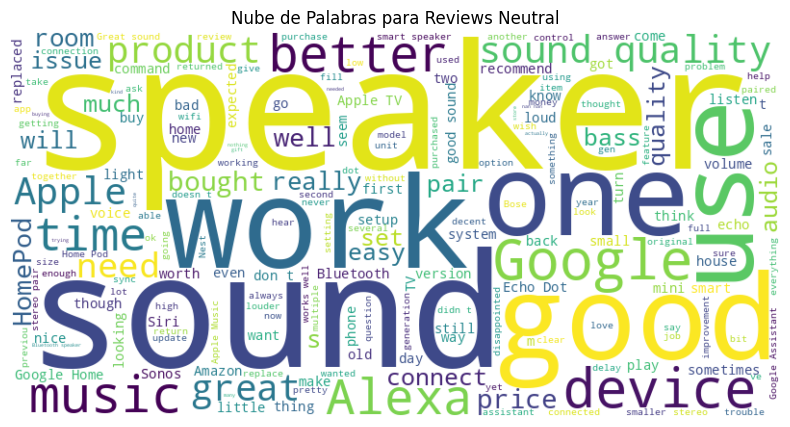

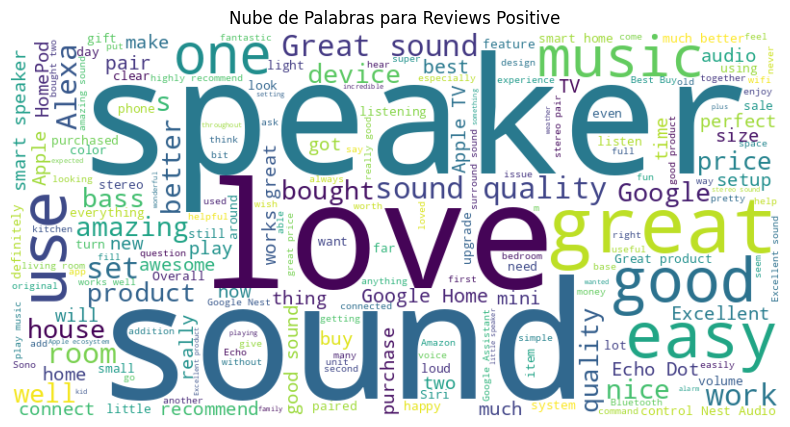

In [ ]:
from wordcloud import WordCloud

# Generar una nube de palabras para las reviews positivas, neutrales y negativas
for sentimiento in ['negative', 'neutral', 'positive']:
    text = ' '.join(df_combined[df_combined['sentimiento_predicho'] == sentimiento]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras para Reviews {sentimiento.capitalize()}')
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


In [ ]:
# Función para extraer los n-gramas más comunes
def obtener_ngrams(texts, n=2, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(texts)
    bag_of_words = vectorizer.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Función para extraer los bigramas y trigramas más comunes por sentimiento y producto
def extraer_ngramas_por_sentimiento(df, producto, sentimiento, top_n=10):
    df_producto_sentimiento = df[(df['producto'] == producto) & (df['sentimiento_predicho'] == sentimiento)]
    texts = df_producto_sentimiento['text'].dropna().tolist()

    bigramas = obtener_ngrams(texts, n=2, top_n=top_n)
    trigramas = obtener_ngrams(texts, n=3, top_n=top_n)

    return bigramas, trigramas


In [ ]:
# Iterar sobre los productos y extraer los n-gramas más comunes por cada sentimiento
for producto in df_combined['producto'].unique():
    print(f"\nProducto: {producto}")

    for sentimiento in ['negative', 'neutral', 'positive']:
        bigramas, trigramas = extraer_ngramas_por_sentimiento(df_combined, producto, sentimiento)

        print(f"\nSentimiento: {sentimiento.capitalize()}")
        print("\nBigrams más comunes:")
        for bigram in bigramas:
            print(f"{bigram[0]}: {bigram[1]}")

        print("\nTrigrams más comunes:")
        for trigram in trigramas:
            print(f"{trigram[0]}: {trigram[1]}")

        print("\n" + "="*50 + "\n")



Producto: Amazon

Sentimiento: Negative

Bigrams más comunes:
did work: 3
work properly: 2
bought use: 1
use outbuilding: 1
outbuilding weak: 1
weak wifi: 1
wifi signal: 1
signal making: 1
making hard: 1
hard ordered: 1

Trigrams más comunes:
did work properly: 2
bought use outbuilding: 1
use outbuilding weak: 1
outbuilding weak wifi: 1
weak wifi signal: 1
wifi signal making: 1
signal making hard: 1
making hard ordered: 1
hard ordered mesh: 1
ordered mesh extender: 1



Sentimiento: Neutral

Bigrams más comunes:
echo dot: 19
good sound: 9
sound quality: 9
amazon echo: 7
easy set: 7
easy setup: 6
works fine: 6
room house: 5
smart home: 5
don know: 5

Trigrams más comunes:
amazon echo dot: 4
white power cord: 3
echo dot 5th: 3
dot 5th gen: 3
easy set use: 3
good sound quality: 2
easy setup use: 2
useful don hands: 2
don hands fingers: 2
hands fingers use: 2



Sentimiento: Positive

Bigrams más comunes:
echo dot: 150
easy set: 82
easy use: 77
sound quality: 76
great sound: 75
works grea